<p align="center">
  <br/>
    <img alt="ScaleDP" src="https://stabrise.com/media/filer_public_thumbnails/filer_public/4a/7d/4a7d97c2-50d7-4b7a-9902-af2df9b574da/scaledplogo.png__1000x300_subsampling-2.webp" width="376" style="max-width: 100%;">
  <br/>
</p>

<p align="center">
    <a target="_blank" href="https://colab.research.google.com/github/StabRise/scaledp-tutorials/blob/master/2.Ocr.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://github.com/stabrise/scaledp/" alt="GitHub"><img src="https://img.shields.io/static/v1?label=GitHub&message=ScaleDP&color=blue&logo=github" /></a>
    <a href="https://pypi.org/project/scaledp/" alt="Package on PyPI"><img src="https://img.shields.io/pypi/v/scaledp.svg" /></a>    
    <a href="https://github.com/stabrise/scaledp/blob/main/LICENSE"><img alt="GitHub" src="https://img.shields.io/github/license/stabrise/scaledp.svg?color=blue"></a>
    <a href="https://stabrise.com"><img alt="StabRise" src="https://img.shields.io/badge/by-StabRise-orange.svg?style=flat&colorA=E1523D&colorB=007D8A"></a>
</p>

## Installation

In [1]:
%%bash
[[ ! "${COLAB_RELEASE_TAG}" ]] && exit
sudo apt install tesseract-ocr

In [ ]:
!pip install scaledp

## Start Spark Session with ScaleDP

In [1]:
from scaledp import *

spark = ScaleDPSession()
spark


24/12/17 11:38:27 WARN Utils: Your hostname, Mykolas-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.185 instead (on interface en0)
24/12/17 11:38:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/17 11:38:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read image from the file to the DataFrame


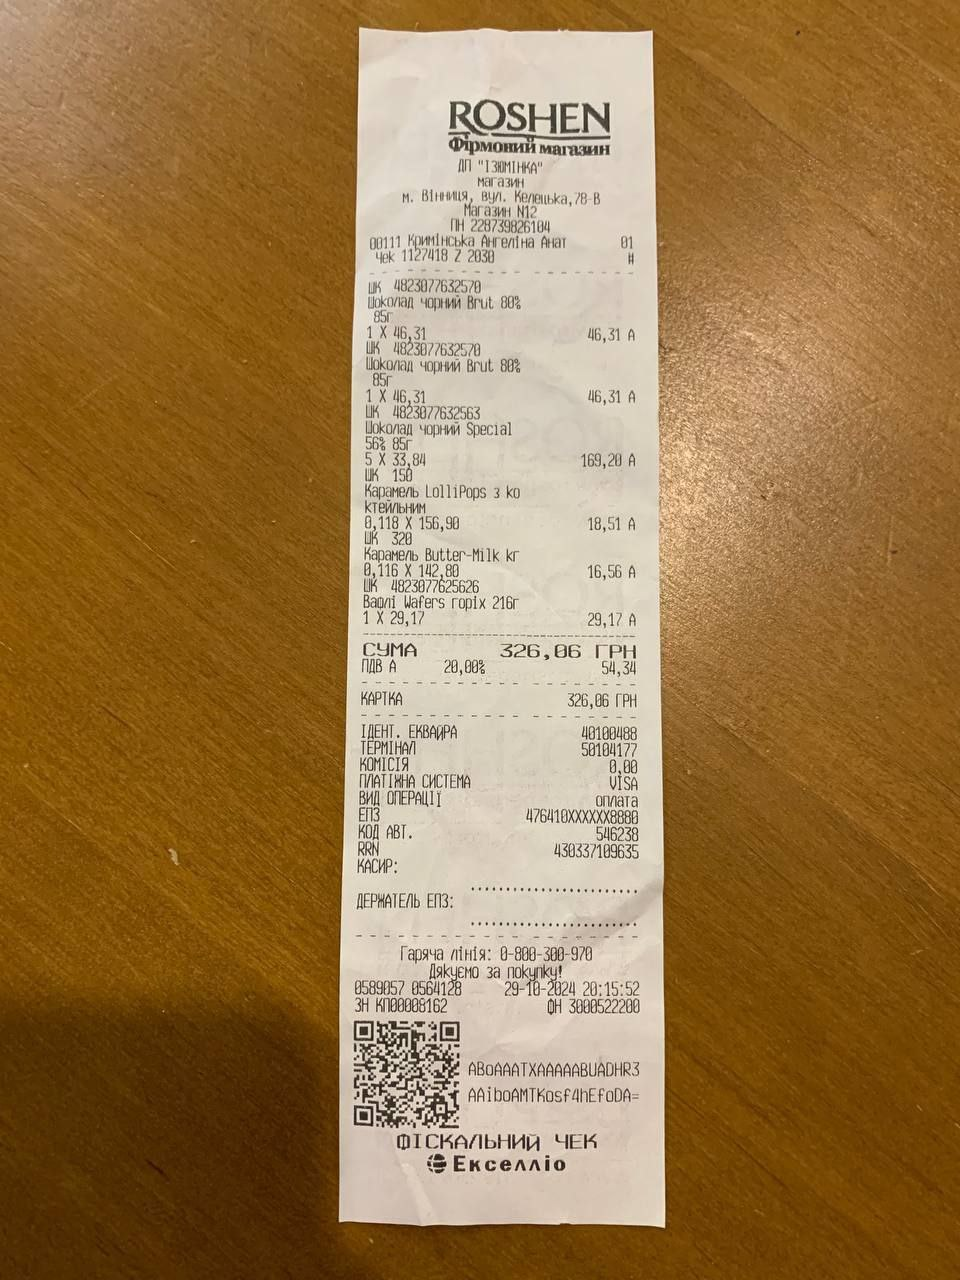

In [20]:
image_example = files('resources/images/receipt.jpg')
#image_example = "/Users/nmelnyk/PycharmProjects/daymeai/datasets/raw_images/photo_5388907960807318670_y.jpg"

df = spark.read.format("binaryFile") \
    .load(image_example)

df.show_image()

## OCR with Tesseract

In [13]:
from pydantic import BaseModel, Field
import json

class ReceiptItem(BaseModel):
    """Purchased items."""
    name: str
    quantity: float
    price_per_unit: float
    hko: str = Field(description="ШКО код")
    price: float


class ReceiptSchema(BaseModel):
    """Receipt."""
    company_name: str
    shop_name: str
    address: str
    tax_id: str
    transaction_date: str = Field(description="Date of the transaction")
    total_amount: float
    items: list[ReceiptItem]

In [10]:
json.dumps(ReceiptSchema.model_json_schema())

'{"$defs": {"ReceiptItem": {"description": "Purchased items.", "properties": {"name": {"title": "Name", "type": "string"}, "quantity": {"title": "Quantity", "type": "number"}, "price_per_unit": {"title": "Price Per Unit", "type": "number"}, "hko": {"description": "\\u0428\\u041a\\u041e \\u043a\\u043e\\u0434", "title": "Hko", "type": "string"}, "price": {"title": "Price", "type": "number"}}, "required": ["name", "quantity", "price_per_unit", "hko", "price"], "title": "ReceiptItem", "type": "object"}}, "description": "Receipt.", "properties": {"company_name": {"title": "Company Name", "type": "string"}, "shop_name": {"title": "Shop Name", "type": "string"}, "address": {"title": "Address", "type": "string"}, "tax_id": {"title": "Tax Id", "type": "string"}, "transaction_date": {"description": "Date of the transaction", "title": "Transaction Date", "type": "string"}, "total_amount": {"title": "Total Amount", "type": "number"}, "items": {"items": {"$ref": "#/$defs/ReceiptItem"}, "title": "It

[Stage 31:>                                                         (0 + 1) / 1]
/Users/nmelnyk/Library/Caches/pypoetry/virtualenvs/scaledp-XFfH1y5S-py3.11/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
0: 640x480 1 receipt, 176.6ms
Speed: 5.9ms preprocess, 176.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)
/Users/nmelnyk/Library/Caches/pypoetry/virtualenvs/scaledp-XFfH1y5S-py3.11/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
ukr+eng
character_height 22
line_tolerance 7.333333333333333
              ROSHEN
                         магазин
               i “TOM HRA"
                 магазин
      


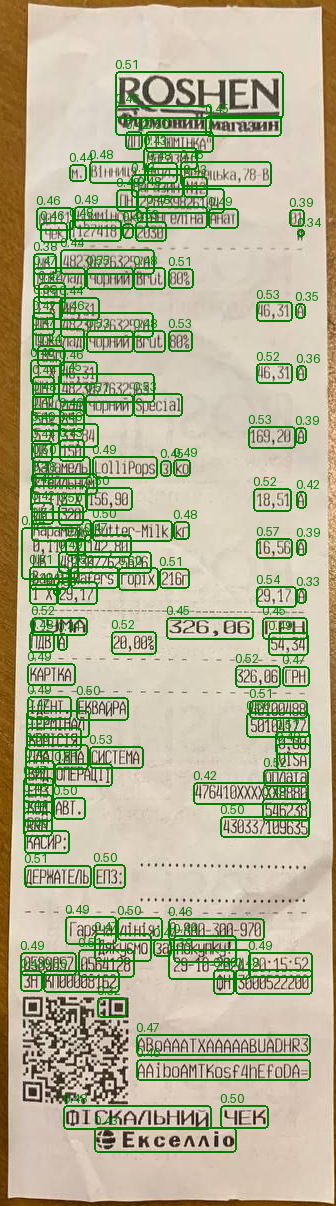

{
    "company_name": "ROSHEN",
    "shop_name": "TOM HRA",
    "address": "м, Вінниця, Вул, Келецька, /B B",
    "tax_id": "228739826104",
    "transaction_date": "23-10-2824 20:15:52",
    "total_amount": 328.06,
    "items": [
        {
            "name": "Шоколад чорний Brut 805",
            "quantity": 1.0,
            "price_per_unit": 46.31,
            "hko": "4823677632570",
            "price": 46.31
        },
        {
            "name": "Шоколад чорний Brut 80%",
            "quantity": 1.0,
            "price_per_unit": 46.31,
            "hko": "4893877632570",
            "price": 46.31
        },
        {
            "name": "Шоколад чорний Special",
            "quantity": 5.0,
            "price_per_unit": 33.84,
            "hko": "4803077632563",
            "price": 169.2
        },
        {
            "name": "Карамель LolliPops 3 ko",
            "quantity": 8.0,
            "price_per_unit": 18.51,
            "hko": "150",
            "price": 148.08
   

In [21]:
pipeline = PipelineModel(stages=[
    DataToImage(inputCol="content", outputCol="image"),
    YoloDetector(device=Device.CPU, keepInputData=True,
        model="/Users/nmelnyk/PycharmProjects/daymeai/apiserver/resources/models/detectors/reciept_segmentation_15.12.2024.pt"),
    ImageCropBoxes(inputCols=["image", "boxes"], outputCol="cropped_image"),
    DocTRTextDetector(inputCol="cropped_image", outputCol="text_boxes", device=Device.CPU, keepInputData=True,
                      model="db_mobilenet_v3_large",scoreThreshold=0.2),
    ImageDrawBoxes(keepInputData=True, inputCols=["cropped_image", "text_boxes"],
                          filled=False, color="green", lineWidth=2,
                          displayDataList=['score']),
    TesseractRecognizer(inputCols=["cropped_image", "text_boxes"],
                        keepFormatting=True,
                        tessLib=TessLib.TESSEROCR.value,
                        scoreThreshold=0.1,
                        keepInputData=True,
                        scaleFactor=2,
                        #lineTolerance=2,
                        lang=["ukr", "eng"],
                        tessDataPath="/usr/local/Cellar/tesseract-lang/4.1.0/share/tessdata/"),
    # TesseractOcr(inputCol="cropped_image", outputCol="text", keepFormatting=True, scaleFactor=1,
    #              keepInputData=True, lang=["ukr", "eng"], scoreThreshold=0.5),
    DSPyExtractor(model="llama-3.3-70b-versatile",
                apiKey="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",
                schema=json.dumps(ReceiptSchema.model_json_schema()))
])

result = pipeline.transform(df).cache()

#result.show_image("cropped_image")
result.show_image("image_with_boxes")
#result.show_text()

print(json.dumps(json.loads(result.select("data.data").collect()[0].data), indent=4, ensure_ascii=False))


## OCR with Surya OCR

In [3]:
pipeline = PipelineModel(stages=[
    DataToImage(inputCol="content", outputCol="image"),
    SuryaOcr(inputCol="image", outputCol="text", partitionMap=False, numPartitions=1, device=Device.CPU, batchSize=5, keepFormatting=True),
])

result = pipeline.transform(df).cache()

result.show_text()

## OCR with DocTR

In [17]:
pipeline = PipelineModel(stages=[
    DataToImage(inputCol="content", outputCol="image"),
    DocTROcr(inputCol="image", outputCol="text", partitionMap=False, numPartitions=1, device=Device.CUDA, batchSize=5, keepFormatting=True),
])

result = pipeline.transform(df).cache()

result.show_text()

/Users/nmelnyk/Library/Caches/pypoetry/virtualenvs/scaledp-XFfH1y5S-py3.11/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
character_height 19
line_tolerance 6.333333333333333
